In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
# from kernels.squared_exponential import SquaredExponential
# from kernels.matern import Matern
from torch.optim import Adam

# import sys
import math
# sys.path.append('/Users/colecitrenbaum/Documents/GPs/gp-quadrature/Tests and Sanity Checks/')
from efgpnd import EFGPND
import warnings
# warnings.filterwarnings("ignore", message=".*disabling cuda.*")


# --- Parameters ---
n = 100  # Number of points
d = 2  # Dimensionality of the input space
true_length_scale =0.15
true_variance = 1
true_noise_variance = 0.2
dtype = torch.float32  # Use float64 as in the original example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
print(f"Using device: {device}")
from cg import ConjugateGradients
# --- Generate Input Points ---
# Generate random points in d-dimensional space from -1 to 1
x = torch.rand(n, d, dtype=dtype, device=device) * 2 - 1


EPSILON = 1e-4

Using device: cpu


In [2]:
# Generate test points (grid of points for visualization if d <= 3)
if d >= 2:
    # Create a grid of points for testing
    grid_points_per_dim = 20
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
elif d==1:
    grid_points_per_dim = 3000
    grid_points = [torch.linspace(x.min()-0.1, 0.1+x.max(), grid_points_per_dim, dtype=dtype, device=device) for _ in range(d)]
    mesh_grid = torch.meshgrid(*grid_points, indexing='ij')
    x_new = torch.stack([grid.flatten() for grid in mesh_grid], dim=1)
else:
    # For higher dimensions, just use random test points
    x_new = torch.rand(1000, d, dtype=dtype, device=device) * 2.4 - 1.2

from vanilla_gp_sampling import sample_gp_fast, sample_gp_matern

# # For squared exponential kernel
samples_se = sample_gp_fast(
    x,
    length_scale=true_length_scale,
    variance=true_variance,
    noise_variance=true_noise_variance
)
# # For Matern kernel
# samples_m32 = sample_gp_matern(
#     x,
#     nu=1.5,  # 3/2 Matern
#     length_scale=true_length_scale,
#     variance=true_variance,
#     noise_variance=true_noise_variance
# )
y = samples_se

In [3]:
sigmasq = 0.2 
from efgpnd import efgp_nd
from kernels.squared_exponential import SquaredExponential
kernel = SquaredExponential(dimension=2, lengthscale=0.1, variance=1, noise_variance=sigmasq)
beta, xis, ytrg, ws, toeplitz = efgp_nd(x, y, kernel=kernel, eps=EPSILON,sigmasq = sigmasq,x_new=x_new,opts={"get_log_marginal_likelihood":True})

/Users/colecitrenbaum/Documents/GPs/gp-quadrature/efgpnd.py:87: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:308.)
  ws  = ws.to(dtype=dtype, device=device)


In [4]:
from efgpnd import negative_log_marginal_likelihood
true_log_marginal_likelihood = negative_log_marginal_likelihood(x, y, kernel.lengthscale, kernel.variance, sigmasq)
print(ytrg['log_marginal_likelihood'],true_log_marginal_likelihood)

tensor(-145.4209) tensor(144.5196)


In [16]:
ws = ws.to(dtype=torch.complex128)
D = torch.diag(ws).to(dtype=torch.complex128) # (mtot**d, mtot**d)
F = torch.exp(1j * 2 * torch.pi * (x @ xis.T))
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))


In [17]:
(F@D@D@torch.conj(F).T).shape

torch.Size([100, 100])

In [18]:
torch.logdet(F@D@D@torch.conj(F).T + sigmasq*torch.eye(n)).real

tensor(-7.6898, dtype=torch.float64)

## Log det stuff







$$\log |K + \sigma^2 I| = \log |\Phi^* \Phi \sigma^{-2} +I|\sigma^2n$$


In [55]:
cg_tol = 1e-10

In [27]:
(D@ F.conj().T @ F @ D).shape

torch.Size([1681, 1681])

In [50]:
true_det = torch.log(torch.det(D@ F.conj().T @ F @ D * sigmasq**(-1) + torch.eye(F.shape[1]).to(dtype=torch.complex128))*sigmasq**(n)).real

In [ ]:
# Fy = fadj(y).reshape(-1)

# rhs   = ws * Fy
# beta  = ConjugateGradients(A_apply, rhs,
#                         torch.zeros_like(rhs),
#                         tol=cg_tol, early_stopping=True).solve()
# alpha = (y - fwd(ws * beta)) / sigmasq # (\tilde{K} +sigma^2 I)^{-1} y

In [48]:
import torch, math

# ------------------------------------------------------------
# 1.  fast mat‑vec  Gv = D T D v
# ------------------------------------------------------------
def make_df_fd_matvec(ws, toeplitz):
    def Gv(v):
        return ws * toeplitz(ws * v)
    return Gv


# ------------------------------------------------------------
# 2.  Hutchinson + Lanczos log‑det
# ------------------------------------------------------------
@torch.no_grad()
def logdet_slq(ws, sigma2, toeplitz,
               *, probes=1000, steps=100,
               dtype=torch.float64, device="cpu",
               eps=1e-18):
    """
    Estimate  log det(I + σ⁻² D T D).

    ws        (m,)            – diagonal weights
    sigma2    float           – noise variance σ²
    toeplitz  callable        – fast Toeplitz mat‑vec
    probes, steps             – Hutchinson & Lanczos params
    eps                       – floor for Ritz eigen‑values
    """
    ws  = ws.to(dtype=dtype, device=device)
    m   = ws.numel()
    σ2  = torch.as_tensor(sigma2, dtype=dtype, device=device)

    # closures ------------------------------------------------
    Gv = make_df_fd_matvec(ws, toeplitz)
    Av = lambda v: v + (1.0 / σ2) * Gv(v)

    logdet_acc = torch.zeros((), dtype=dtype, device=device)

    for _ in range(probes):
        # ---------- probe ------------------------------
        z = torch.empty(m, dtype=dtype, device=device).bernoulli_(0.5)
        z = z.mul_(2).sub_(1)           # ±1  Rademacher
        q = z / z.norm()                # safer than sqrt(m)

        # ---------- Lanczos ----------------------------
        alphas, betas = [], []
        q_prev, beta_prev = torch.zeros_like(q), torch.tensor(
            0.0, dtype=dtype, device=device
        )

        for _ in range(steps):
            v     = Av(q) - beta_prev * q_prev
            # Ensure both vectors have the same dtype before dot product
            q_conj = q.conj().to(dtype=v.dtype)
            alpha = torch.dot(q_conj, v).real
            v    -= alpha * q
            beta  = v.norm()

            alphas.append(alpha)
            betas.append(beta)

            if beta < 1e-12:            # converged early
                break
            q_prev, beta_prev = q, beta
            q = v / beta

        k = len(alphas)
        T = torch.zeros(k, k, dtype=dtype, device=device)
        for i in range(k):
            T[i, i] = alphas[i]
            if i < k - 1:
                T[i, i + 1] = betas[i]      # ← correct β indexing
                T[i + 1, i] = betas[i]

        # ---------- Gauss–Lanczos quadrature ----------
        evals, evecs = torch.linalg.eigh(T)
        evals.clamp_min_(eps)               # avoid log(≤0)
        w1   = evecs[0]
        quad = (w1**2 * torch.log(evals)).sum() * (z.norm() ** 2)
        logdet_acc += quad

    # The SLQ method estimates log det(I + σ⁻² D T D)
    # But we want log det(D T D σ⁻² + I) * σ²ⁿ
    # Using the matrix determinant lemma: det(I + AB) = det(I + BA)
    # So det(I + σ⁻² D T D) = det(I + σ⁻² T D²)
    # And det(D T D σ⁻² + I) = det(I + D T D σ⁻²)
    # Therefore, we need to add n*log(σ²) to get the full determinant
    
    logdet = (logdet_acc / probes).item() + n * math.log(sigma2)
    
    
    return logdet


sigma2 = sigmasq

val = logdet_slq(ws, sigma2, toeplitz,
                    probes=15, steps=25,
                    dtype=dtype, device=device)



log‑det ≈ -9.734883


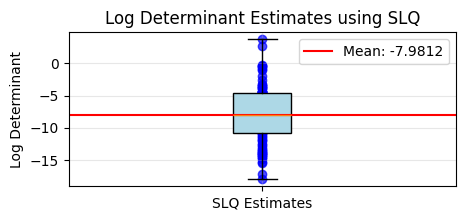

Mean estimate: -7.981159
Standard deviation: 4.359986


In [53]:
dets = []
for test in range(10):
    val = logdet_slq(ws, sigma2, toeplitz,
                    probes=15, steps=25,
                    dtype=dtype, device=device)
    dets.append(val)

# Create a boxplot of the determinant estimates
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean and standard deviation of our estimates
mean_det = np.mean(dets)
std_det = np.std(dets)

# Create a figure
plt.figure(figsize=(5, 2))

# Create boxplot
plt.boxplot(dets, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Add individual points for better visualization
plt.scatter(np.ones(len(dets)), dets, color='blue', alpha=0.7)

# Add a horizontal line for the mean
plt.axhline(y=mean_det, color='red', linestyle='-', label=f'Mean: {mean_det:.4f}')

# If we have a true determinant value, plot it
# Uncomment and modify this if you have the true value
# true_det = ...
# plt.axhline(y=true_det, color='green', linestyle='--', label=f'True Value: {true_det:.4f}')

plt.title('Log Determinant Estimates using SLQ')
plt.ylabel('Log Determinant')
plt.xticks([1], ['SLQ Estimates'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean estimate: {mean_det:.6f}")
print(f"Standard deviation: {std_det:.6f}")
